# Aula 15: Aprendizado Supervisionado e Regressão Linear

![img](img/meme2.jpg)

## Previsão De Demanda por Bikes

Imagine que você é contratado por uma empresa de aluguel de bicicletas. Nessa empresa, o modelo de negócio é de aluguel de bicicletas para o dia inteiro. Sua primeira tarefa como cientista de dados e responder duas perguntas fundamentais para a empresa:

1. **Qual será a demanda de bicicletas na cidade em 10 dias?** Conseguindo estimar a quantidade de bicicletas que serão utilizadas com 10 dias de antecedência, a empresa terá tempo suficiente para adaptar o seu estoque e garantir que não falte bicicletas para ninguém

  
2. **Qual o impacto da campanha de marketing da empresa da demanda por bicicletas?**. Recentemente, a empresa vem investindo em marketing para aumentar a demanda de bicicletas, mas ainda não se sabe quantos clientes a mais essa campanha vem trazendo. Para ter melhores investimentos em marketing, você precisará estimar esse efeito.


### Bibliotecas Carregando os Dados

A primeira etapa do nosso processo é importar as bibliotecas que vamos utilizar e carregar os dados. Vamos usar

Nossos dados vem num arquivo [`.parquet`](https://parquet.apache.org/), que é otimizado pra trabalhar com o ecosistema Hadoop. É bem mais eficiente do que arquivos `.csv`. 

[mais sobre formator...](https://www.datanami.com/2018/05/16/big-data-file-formats-demystified/)

* city: cidade.
* dteday: dia do ano (YYYY-MM-DD).
* season: Índice de Estação do ano (1,2,3,4).
* yr: Índice de ano (1 e 2).
* mkt: Indicador de mês com propaganda na cidade.
* mnth: Mês do ano (1 a 12).
* holiday: Indicador de férias
* weekday: Dia da semana (1 a 7).
* workingday: Indicador de dia útil (se não for `holiday` nem final de semana). 
* weathersit: Situação do tempo
    1. Limpo, Poucas nuvens, Parcialmente nublado
    2. Neblina e nublado, neblina e algumas nuvens, neblina e poucas nuvens, neblina
    3. Neve suave, Chuva suave e raios, chuva suave
    4. Chuva pesada, Chuva pesada, granizo e raios, chuva e neblina.
* temp: temperatura (em celsius) normalizada pelo máximo (41)
* atemp: sensação térmica (em celsius) normalizada pelo máximo (50)
* hum: umidade relativa do ar normalizada pelo máximo (100)
* windspeed: velocidade do vento normalizada pelo máximo (67)
* stock: estoque de bicicletas para locação
* cnt: número de bicicletas alugadas.
* target: número de bicicletas alugadas daqui a 10 dias.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf

import sklearn, matplotlib, statsmodels

print("Pandas:,", pd.__version__)
print("Numpy:,", np.__version__)
print("Sklearn:,", sklearn.__version__)
print("statsmodels:,", statsmodels.__version__)
print("matplotlib:,", matplotlib.__version__)

Pandas:, 0.24.2
Numpy:, 1.16.2
Sklearn:, 0.20.3
statsmodels:, 0.10.0
matplotlib:, 3.0.3


In [2]:
data = pd.read_csv("bike_data.csv")

Sempre que carregar os dados é bom checar o tamanho do dataset, tanto o número de linhas quanto o número de colunas. Além disso, eu gosto de mostrar algumas linhas dos dados para ver se tem algo muito esquisito. 

In [3]:
print(data.shape)

(146200, 17)


é também uma boa ideia olhar os tipos dos dados. O que pode acontecer é ter variáveis numéricas mas que por algum bug estão sendo representadas como strings. Não é o caso aqui

In [4]:
data.dtypes

city           object
dteday         object
season          int64
yr              int64
mkt             int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
stock           int64
cnt             int64
target        float64
dtype: object

## Análise Exploratória
Análise exploratória serve para desvendar um pouco do processo gerador de dados. Quanto mais você souber sobre como os dados são gerados, melhor será suas chances de usar a técnica de modelagem mais adequada. Algumas análises são padrões em todos os processos de análise exploratória:

    1. Análise de distribuição. Ex: qual a média, mínimo e máximo de cada variável
    2. Análise de dados faltantes. Ex: Quais variáveis têm dados faltantes? Qual a proporção de dados faltantes por variável? Porque esses dados estão faltando? É um bug ou uma característica do processo gerador de dados?
    3. Variáveis categóricas. Existem variáveis categóricas? Qual a cardinalidade das variáveis categóricas? As categorias são ordenadas ou sem ordem?
    4. Correlação. Qual a correlação entre variáveis?

Outros análises são particulares de cada problema de data science. Você consegue pensar em pelo menos mais uma análise que vale a pena fazer e que te de insights sobre o processo gerador de dados?

    5. Censura: Quais as limitações do target? Há algum processo de espera temporal entre a observação das variáveis e a observação do target (em problemas de previsão, a resposta geralmente é sim!). Como é esse processo. Há alguma outra variável que limite o target?


### Análise de distribuição

A distribuição das variáveis faz sentido. Não há valores negativos em nenhuma delas, o que faz sentido dada as suas descrições. Algumas variáveis são entre 0 e 1 (yr, holiday, workingday) o que faz sentido também. 

In [5]:
data.describe().round(4)

,season,yr,mkt,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,stock,cnt,target
count,146200.0000,146200.0000,146200.0000,146200.0000,146200.0000,146200.0000,146200.0000,146200.0000,146200.0000,146200.0000,146200.0000,146200.0000,146200.0000,146200.0000,144200.0000
mean,2.4966,0.5007,0.3179,6.5198,0.0287,2.9973,0.6840,1.3953,0.4954,0.4744,0.6279,0.1905,4867.5203,4641.0334,4690.4309
std,1.1101,0.5000,0.4657,3.4496,0.1670,2.0034,0.4649,0.5445,0.1829,0.1629,0.1423,0.0774,1997.8650,1952.0898,1919.0088
min,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0591,0.0791,0.0000,0.0224,50.0000,0.0000,0.0000
25%,2.0000,0.0000,0.0000,4.0000,0.0000,1.0000,0.0000,1.0000,0.3367,0.3377,0.5200,0.1349,3473.7500,3278.0000,3350.0000
50%,3.0000,1.0000,0.0000,7.0000,0.0000,3.0000,1.0000,1.0000,0.4983,0.4867,0.6267,0.1810,4903.0000,4677.0000,4709.0000
75%,3.0000,1.0000,1.0000,10.0000,0.0000,5.0000,1.0000,2.0000,0.6558,0.6092,0.7304,0.2332,6335.0000,6076.0000,6101.0000
max,4.0000,1.0000,1.0000,12.0000,1.0000,6.0000,1.0000,3.0000,0.8617,0.8409,0.9725,0.5075,10990.0000,9867.0000,9867.0000


### Valores Nulos
Apenas o target tem valores nulos. Por que isso?

In [6]:
data.isna().mean()

city          0.00000
dteday        0.00000
season        0.00000
yr            0.00000
mkt           0.00000
mnth          0.00000
holiday       0.00000
weekday       0.00000
workingday    0.00000
weathersit    0.00000
temp          0.00000
atemp         0.00000
hum           0.00000
windspeed     0.00000
stock         0.00000
cnt           0.00000
target        0.01368
dtype: float64

### Cardinalidade
Algumas variáveis categóricas têm baixa cardinalidade (season, yr, month, holiday, weekday...). A variável com mais categorias e `city`.

In [7]:
data.apply(pd.Series.nunique)

city           200
dteday         731
season           4
yr               2
mkt              2
mnth            12
holiday          2
weekday          7
workingday       2
weathersit       3
temp           499
atemp          690
hum            595
windspeed      650
stock         9540
cnt           9105
target        9083
dtype: int64

## Correlação
Ano tem uma alta correlação positiva com o target. Isso indica que a demanda por bicicletas provavelmente vem crescendo com o tempo. Também podemos ver que `cnt` tem uma alta correlação com o target. Isso também faz sentido intuitivo, já que a demanda do passado deve ajudar a prever a demanda do futuro. `mkt` tem uma forte correlação negativa com o target. Por que isso?

In [8]:
data.corr()["target"]

season        0.233598
yr            0.543720
mkt          -0.120120
mnth          0.188007
holiday      -0.015171
weekday      -0.042023
workingday    0.002308
weathersit   -0.079299
temp          0.536167
atemp         0.533684
hum           0.025704
windspeed    -0.083605
stock         0.675013
cnt           0.691051
target        1.000000
Name: target, dtype: float64

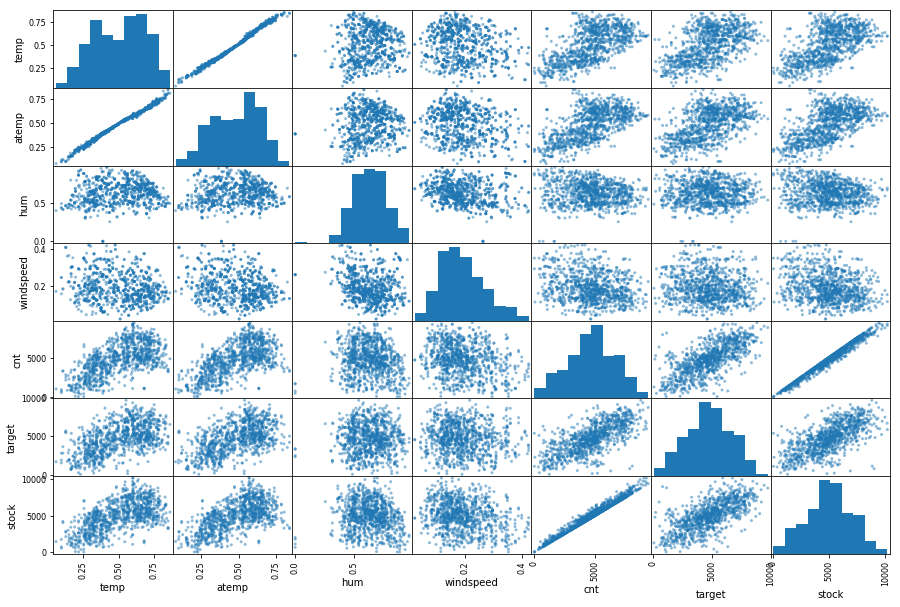

In [9]:
from pandas.plotting import scatter_matrix

continuous_cols = ["temp","atemp","hum","windspeed","cnt","target", "stock"]
scatter_matrix(data.sample(1000)[continuous_cols], figsize=(15, 10))
plt.show()

## Regressão Linear

Regressão linear modela o target como uma combinação das features:
$$y_i = \beta_0 + \beta_1 X1_i + \beta_2 X2_i + ... + \beta_k Xk_i + \epsilon$$

Em notação de matriz

$$\pmb{y}_{n1} = \pmb{X}_{nd} \pmb{\beta}_{d1} + \pmb{\epsilon}_{n1}$$

Intuitivamente, regressão linear é simplesmente enxergar o target como uma soma ponderada das variáveis explicativas. O desafio consiste em achar o peso associado a cada variável dessa soma ponderada.

### MQO

Uma forma de achar esses pesos é minimizando a soma dos erros quadráticos. Isso nos dará o estimador MQO, que é o mais comumente utilizado. A vantagem do estimador MQO é que ele tem uma solução algébrica, então é muito rápido de computar. Isso quase nunca será verdade para modelos de aprendizado de máquina. Geralmente é mais comum soluções computacionais, que envolver várias iterações.

Aqui está a derivação:

$$
\pmb{\epsilon}^T  \pmb{\epsilon} = (\pmb{y} - \pmb{\hat{\beta}}X)^T(\pmb{y} - \pmb{\hat{\beta}} X) \\= \pmb{y}^T \pmb{y} - \pmb{\hat{\beta}}^T X^T \pmb{y} - \pmb{y}^T X \pmb{\hat{\beta}} + \pmb{\hat{\beta}} X^T X \pmb{\hat{\beta}} \\= \pmb{y}^T \pmb{y} - 2\pmb{\hat{\beta}}^T X^T \pmb{y} + \pmb{\hat{\beta}} X^T X \pmb{\hat{\beta}}
$$

$$
\frac{\partial \pmb{\epsilon}^T \pmb{\epsilon}}{\partial \pmb{\hat{\beta}}} = -2X^T\pmb{y} + 2X^T X \pmb{\hat{\beta}} = 0
$$

A solução final é essa abaixo. Você não precisa se preocupar com a derivação, mas é muito importante entender a fórmula abaixo, pois ela te dará uma boa intuição de como regressão linear funciona. 

$$\pmb{\hat{\beta}} = (X^T X)^{-1} X^T \pmb{y}$$

![img](https://matheusfacure.github.io/img/tutorial/bowlregr.png)

![img](https://matheusfacure.github.io/img/tutorial/graddesc.gif)


[Mais sobre MQO...](https://matheusfacure.github.io/2017/02/15/MQO-formula-analitica/)


#### O que podemos tirar dessa fórmula
1. Para encontrar os pesos (ou parâmetros) da regressão, é preciso inverter uma matriz: \\(X^T X\\). Note que essa é a matriz de covariância suas suas variáveis! Ela será uma matriz quadráticas e terá o mesmo número de linhas e colunas que variáveis do seu modelo. Se o seu modelo tiver muitas variáveis (+10000) essa matriz será enorme e a inversão ficará bem pesada!


2. Se uma ou mais variáveis for uma combinação linear das outras, essa matriz de correlação será não inversível! Por isso, você não pode criar variáveis como \\(x1+x2\\) e incluir no seu modelo MQO.

### Regressão Pela Origem

$$y_i = \beta_0 + \epsilon$$




In [10]:
model = smf.ols('target ~ 1', data=data).fit()
model.summary()

/Users/matheus.facure/miniconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1657: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                      -inf
Date:                Thu, 18 Jul 2019   Prob (F-statistic):                nan
Time:                        21:48:36   Log-Likelihood:            -1.2947e+06
No. Observations:              144200   AIC:                         2.589e+06
Df Residuals:                  144199   BIC:                         2.589e+06
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4690.4309      5.054    928.150      0.000    4680.526    4700.336
==============================================================================
Omnibus:                     5055.739   Durbin-Watson:                   0.362
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2449.848
Skew:                          -0.101   Prob(JB):                         0.00
Kurtosis:                       2.394   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Note como o valor do Intercept é igual o da média não condicional: 4573.57

Média:  4690.4308599167825


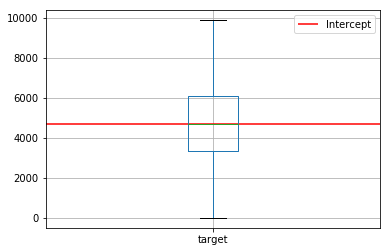

In [11]:
print("Média: ", data["target"].mean())
data[["target"]].boxplot()
plt.hlines(y=model.params.Intercept, xmin=0, xmax=2, color="r", label="Intercept")
plt.legend()
plt.show()

## O Famoso .fit() .predit()

![img](img/machineLearning.png)

In [12]:
model = smf.ols('target ~ 1', data=data).fit()

y_hat = model.predict(data)

## Calculando o Erro do Da Nossa Previsão

In [13]:
# parecido com data["pred"] = data["target"].mean()
# outra forma seria data_pred = data.assign(pred = lambda df: df["target"].mean())

data_pred = (data
             .assign(**{"pred": model.predict(data)})
             .dropna())

data_pred[["target", "pred"]].head(10)

,target,pred
0,1257.0,4690.43086
1,1096.0,4690.43086
2,1430.0,4690.43086
3,885.0,4690.43086
4,1210.0,4690.43086
5,1109.0,4690.43086
6,1051.0,4690.43086
7,592.0,4690.43086
8,1910.0,4690.43086
9,2018.0,4690.43086


### Qual seria uma boa forma de avaliar a qualidade das nossas previsões?

Média dos erros?   
\\(\frac{1}{N} \sum \epsilon\\)

In [14]:
# Média dos erros?
(data_pred["target"] - data_pred["pred"]).mean().round(4)

-0.0

#### Média do Erro Absoluto
\\(\frac{1}{N} \sum |\epsilon|\\)

#### Média do Erro Quadrático
\\(\frac{1}{N} \sum \epsilon^2\\)

#### Raiz da Média do Erro Quadrático
\\( \sqrt{ \frac{1}{N} \sum \epsilon^2} \\)


### R2
Parte de cima é a soma do erro quadrático, também conhecida como soma dos resíduos quadráticos. Essa parte nos diz **o quanto da variância do target que é explicado pelo modelo**.  

A parte de baixo é a soma total dos quadrados. Ela diz a variância do target. 

Intuitivamente, o \\(R^2\\) nos dá a proporção da variância do target que é explicada pelo modelo depois de termos considerado a média. Usar a média como previsão terá um \\(R^2\\) de 0. Qualquer previsão pior do que a média terá um \\(R^2\\) negativo. Qualquer previsão melhor que a média terá um \\(R^2\\) positivo, no máximo igual a 1. 

\\(R^2(y, \hat{y}) = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}\\)

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_pred(df_pred):
    
    print("Erro Absoluto Médio:, ", mean_absolute_error(df_pred["target"], df_pred["pred"]))
    print("Erro Quadrático Médio:, ", mean_squared_error(df_pred["target"], df_pred["pred"]))
    print("Raiz Quadrada do Erro Quadrático Médio:, ",
          np.sqrt(mean_squared_error(df_pred["target"], df_pred["pred"])))
    print("R2: ", r2_score(df_pred["target"], df_pred["pred"]))


evaluate_pred(data_pred)

Erro Absoluto Médio:,  1563.3127915612656
Erro Quadrático Médio:,  3682569.2493389277
Raiz Quadrada do Erro Quadrático Médio:,  1919.0021493836132
R2:  0.0


### Qual a Vantagem de Cada Métrica? Qual a Desvantágem?

```
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
```

### Erro Quadrático
Erro quadrático penalisa exponencialmente mais os erros. Assim, erros grande são muito piores que erros pequenos. Uma desvantágem é que a escala do erro quadrático é o quadrado da escala do target, fazendo com que a interpretação seja difícil.

### Erro Absoluto
O erro absoluto é na mesma escala do target, tendo interpretação fácil. Ele pondera linearmente erros maiores e por isso é mais robusto a outliers.

### Raíz Quadrada do Erro Quadrático
Mesmas vantagens e desvantagens do erro quadrático com a vantágem adicional de ser mais fácil de interpretar. A escolha entre esse erro e o erro absoluto vai do quanto você quer penalizar erros maiores. 

![img](https://matheusfacure.github.io/img/tutorial/cost-median-mean.png)

### $R^2$
O $R^2$ é uma métrica entre zero e um e é fácilmente interpretável como a explicação da variância do target pelo modelo. O $R^2$ também nos dá quão melhor estamos a partir da média (benchmark inicial). Porém, não é fácil saber a magnitude dos erros só pelo $R^2$.

Tutorial Completo em
https://matheusfacure.github.io/2017/03/03/func-custo-regr/

### Regressão Univariada

In [16]:
results = smf.ols('target ~ temp', data=data).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                 5.818e+04
Date:                Thu, 18 Jul 2019   Prob (F-statistic):               0.00
Time:                        21:48:37   Log-Likelihood:            -1.2703e+06
No. Observations:              144200   AIC:                         2.541e+06
Df Residuals:                  144198   BIC:                         2.541e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1868.8718     12.451    150.093      0.000    1844.467    1893.276
temp        5656.9871     23.453    241.201      0.000    5611.019    5702.955
==============================================================================
Omnibus:                     1207.914   Durbin-Watson:                   0.556
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              838.132
Skew:                           0.061   Prob(JB):                    1.00e-182
Kurtosis:                       2.647   Cond. No.                         6.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

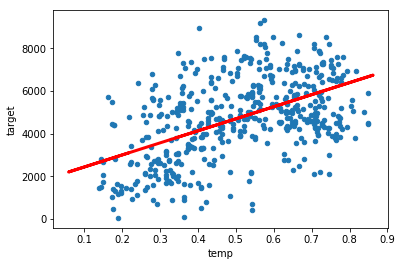

In [17]:
data.sample(500).plot.scatter(y="target", x="temp")
plt.plot(data["temp"], results.params.Intercept + data["temp"] * results.params.temp, color="r", lw=3)
plt.show()

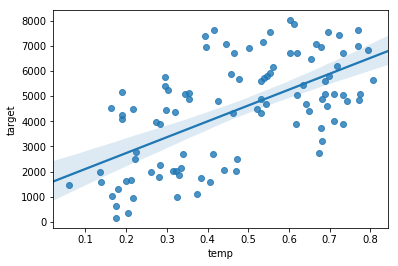

In [18]:
import seaborn as sns

sample = data.sample(100)

_ = sns.regplot(x=sample["temp"], y=sample["target"])

### Computando o Erro

In [19]:
data_pred = (data
             .assign(**{"pred": results.predict(data)})
             .dropna())

In [20]:
evaluate_pred(data_pred)

# No caso da média binada por temp era:
# Erro Absoluto Médio:,  1218.5266209715355
# Erro Quadrático Médio:,  2240670.3967063157
# Raiz Quadrada do Erro Quadrático Médio:,  1496.886901775253
# R2:  0.3673678353248824

Erro Absoluto Médio:,  1319.6358254441452
Erro Quadrático Médio:,  2623921.8936939654
Raiz Quadrada do Erro Quadrático Médio:,  1619.852429603995
R2:  0.2874752065653632


## Exercício:  Regressão Univariada: Modelo AR

Modelos AR (Auto-Regressivo) são extremamente poderosos em contexto onde há noção de tempo nos seus dados. A ideia é simplesmente usar a variável target no passado para prever a variável target no futuro. 



# Regressão Multivariada

Você pode incluir mais de uma variável no seu modelo. Quando faz isso, os pesos tem uma interpretação tudo mais constante.

In [21]:
results = smf.ols('target ~ mkt + temp', data=data).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                 2.929e+04
Date:                Thu, 18 Jul 2019   Prob (F-statistic):               0.00
Time:                        21:48:38   Log-Likelihood:            -1.2701e+06
No. Observations:              144200   AIC:                         2.540e+06
Df Residuals:                  144197   BIC:                         2.540e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1950.1595     13.323    146.374      0.000    1924.046    1976.272
mkt         -157.7149      9.260    -17.033      0.000    -175.864    -139.566
temp        5594.6496     23.714    235.922      0.000    5548.171    5641.129
==============================================================================
Omnibus:                     1079.365   Durbin-Watson:                   0.556
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              761.606
Skew:                           0.057   Prob(JB):                    4.16e-166
Kurtosis:                       2.663   Cond. No.                         7.39
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Dummies

Variáveis categóricas podem entrar no modelo, mas para isso precisamos codificá-las em dummies. Dummies são colunas binárias que são 1 quando uma das categorias está presente e zero quando a categoria não está presente.

In [22]:
dummie_df = pd.DataFrame({"sex": ["H", "M", "H", "H", "M", "M"]})
dummie_df

,sex
0,H
1,M
2,H
3,H
4,M
5,M


In [23]:
pd.get_dummies(dummie_df, "sex")

,sex_H,sex_M
0,1,0
1,0,1
2,1,0
3,1,0
4,0,1
5,0,1


**Importante:** Se você incluir todas as colunas das dummies, uma coluna será linearmente dependente das outras!!! Isso fará com que seu modelo quebre. Por isso, nós sempre deixamos uma dummie de fora e a chamamos de baseline.

No exemplo abaixo, podemos ver que, mantidos mkt e temp constantes, devemos esperar uma demanda 1042.1929 maior na estação 2 (season 2) do que na estação 1 (baseline).

Nesse caso, usamos `C(season)` para converter season de numérica em categórica. Por que seria um problema simplesmente usar o valor numérico de season?

In [24]:
results = smf.ols('target ~ mkt + temp + C(season)', data=data).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                 1.331e+04
Date:                Thu, 18 Jul 2019   Prob (F-statistic):               0.00
Time:                        21:48:39   Log-Likelihood:            -1.2673e+06
No. Observations:              144200   AIC:                         2.535e+06
Df Residuals:                  144194   BIC:                         2.535e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1858.1699     15.737    118.076      0.000    1827.326    1889.014
C(season)[T.2]  1042.1929     15.524     67.134      0.000    1011.766    1072.620
C(season)[T.3]   682.7784     20.324     33.594      0.000     642.943     722.614
C(season)[T.4]   690.3093     13.037     52.951      0.000     664.757     715.861
mkt             -113.7051      9.108    -12.484      0.000    -131.557     -95.853
temp            4519.1271     40.778    110.823      0.000    4439.204    4599.051
==============================================================================
Omnibus:                      487.750   Durbin-Watson:                   0.563
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              401.367
Skew:                           0.061   Prob(JB):                     6.98e-88
Kurtosis:                       2.773   Cond. No.                         14.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Incluindo Não Linearidades

### Variáveis Exponenciais
Variáveis quadráticas são boas quando você acha que o há um ponto de máximo ou mínimo da relação entre target e variável dependente. Por exemplo, é bem provável que conforme a temperatura aumente, a demanda de bike aumente até certo ponto. No entanto, conforme a temperatura vai ficando muito alta, é provável que a demanda comece a cair.

In [25]:
results = smf.ols('target ~ mkt + temp + np.square(temp) + C(season)', data=data).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                 1.165e+04
Date:                Thu, 18 Jul 2019   Prob (F-statistic):               0.00
Time:                        21:48:39   Log-Likelihood:            -1.2662e+06
No. Observations:              144200   AIC:                         2.532e+06
Df Residuals:                  144193   BIC:                         2.532e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         485.4360     32.562     14.908      0.000     421.616     549.256
C(season)[T.2]    894.0859     15.707     56.923      0.000     863.301     924.871
C(season)[T.3]    833.4095     20.406     40.841      0.000     793.414     873.405
C(season)[T.4]    494.5839     13.560     36.473      0.000     468.006     521.162
mkt              -100.7169      9.040    -11.141      0.000    -118.436     -82.998
temp              1.16e+04    152.764     75.907      0.000    1.13e+04    1.19e+04
np.square(temp) -7501.2699    156.146    -48.040      0.000   -7807.313   -7195.227
==============================================================================
Omnibus:                      311.487   Durbin-Watson:                   0.583
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              251.026
Skew:                           0.010   Prob(JB):                     3.09e-55
Kurtosis:                       2.797   Cond. No.                         68.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Variáveis De Interação
Variáveis quadráticas são boas quando você acha que o há um ponto de máximo ou mínimo da relação entre target e variável dependente. Por exemplo, é bem provável que conforme a temperatura aumente, a demanda de bike aumente até certo ponto. No entanto, conforme a temperatura vai ficando muito alta, é provável que a demanda comece a cair.

In [26]:
results = smf.ols('target ~ temp + np.square(temp) + windspeed*atemp', data=data).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                 1.322e+04
Date:                Thu, 18 Jul 2019   Prob (F-statistic):               0.00
Time:                        21:48:40   Log-Likelihood:            -1.2675e+06
No. Observations:              144200   AIC:                         2.535e+06
Df Residuals:                  144194   BIC:                         2.535e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -1005.0370     51.338    -19.577      0.000   -1105.658    -904.416
temp             1.624e+04    259.697     62.546      0.000    1.57e+04    1.68e+04
np.square(temp) -1.012e+04    138.971    -72.844      0.000   -1.04e+04   -9850.796
windspeed        4162.7805    185.652     22.423      0.000    3798.907    4526.654
atemp            1153.0019    250.687      4.599      0.000     661.660    1644.344
windspeed:atemp  -1.01e+04    395.490    -25.550      0.000   -1.09e+04   -9329.672
==============================================================================
Omnibus:                      586.368   Durbin-Watson:                   0.604
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              439.761
Skew:                          -0.021   Prob(JB):                     3.22e-96
Kurtosis:                       2.733   Cond. No.                         144.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Exercícios

1. Na regressão acima, o coeficiente de mkt é negativo. A interpretação é que, mantendo a temperatura constante, a presença da campanha de mkt está associada a uma **diminuição** na demanda. Isso faz sentido? Por que? Você consegue encontrar o impacto da campanha de mkt na demanda?


2. Tente conseguir um modelo de regressão que te de mais de 60% de \\(R^2\\).
